In [1]:
# !python -m pip install "gymnasium[atari]"
# !python -m pip install "gymnasium[accept-rom-license, atari]"
# !pip install shimmy

In [2]:
import matplotlib.pyplot as plt
import gymnasium as gym
import seaborn as sns
import numpy as np

import ale_py
import shimmy
import joblib
import os

from gym import wrappers

| **Value** | **Meaning** |
|:---------:|:-----------:|
| 0 | NOOP |
| 1 | FIRE |
| 2 | RIGHT |
| 3 | LEFT |
| 4 | RIGHTFIRE |
| 5 | LEFTFIRE |

# General Functions

In [3]:
def show_obs(obs):
    """ 
    Simple display of image observation 
    
    Args:
    `obs` : np.ndarray
    - Observation from the environment
    """
    plt.figure(figsize=(16,10))
    plt.imshow(obs)
    plt.show()
    return

# Policy Functions

In [4]:
def discount_rewards(rewards):
    """ 
    Take 1D array of rewards and compute discounted version
    Most recent action has the greatest weight 
    
    Args:
    `rewards` : np.ndarray
    - Observed rewards over time
    - ndim : 1
    """
    discounted_rewards = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(range(0, rewards.size)):
        running_add = running_add * gamma + rewards[t]
        discounted_rewards[t] = running_add
    return discounted_rewards

# Run Constants

In [5]:
# batch_size = 64 # used to perform a RMS prop param update every batch_size steps
# learning_rate = 1e-2 # learning rate used in RMS prop
# gamma = 0.99 # discount factor for reward
# decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2

# Config flags - video output and res
resume = True # resume training from previous checkpoint (from save.p  file)?
render = False # render video output?
print_ = False # print each observation
show = False
zero_grad = True
corner_correct = True

timer_i = 1000 # number of iterations without reward before noise is intentionally greater than signal

record_probs = True
record_rewards = True
record_eps_iters = True
save_path = 'model.pt'

# Model Instantiation

In [6]:
OBS_SHAPE = (210, 160)
XMIN = 26
XMAX = 196
YMIN = 14
YMAX = 144
SHAPE = (XMAX - XMIN, YMAX - YMIN)
DOWNSAMPLE = False
DIM = np.prod(SHAPE) // 4 if DOWNSAMPLE else np.prod(SHAPE)

action_dict = {
    0 : 'NOOP',
    1 : 'FIRE',
    2 : 'RIGHT',
    3 : 'LEFT',
    4 : 'RIGHTFIRE',
    5 : 'LEFTFIRE'
}
ACTIONS = [0,1,2,3,4,5] # modify to limit available actions
N_CLASSES = len(ACTIONS)

print('Input Shape:', SHAPE)
print('Input Dimensionality:', DIM)

def preprocess(obs, downsample=True, xmin=26, xmax=196, ymin=10, ymax=144):
    assert obs.shape == (210, 160)
    I = obs[xmin:xmax,ymin:ymax] # crop - remove 35px from start & 25px from end of image in x, to reduce redundant parts of image (i.e. after ball passes paddle)
    if downsample:
        I = I[::2,:]
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else to 1
    return I.astype(np.float32).ravel() # ravel flattens an array and collapses it into a column vector

# def max_pool(input_image, pool_size=2, stride=2):
#     assert input_image.ndim == 2
#     output_shape = ((input_image.shape[0] - pool_size) // stride) + 1
    
#     # Create an empty output array
#     output_image = np.zeros((output_shape, output_shape))
    
#     # Loop through the input image and apply the max pooling operation
#     for i in range(0, input_image.shape[0] - pool_size + 1, stride):
#         for j in range(0, input_image.shape[1] - pool_size + 1, stride):
#             output_image[i // stride, j // stride] = np.max(input_image[i:i+pool_size, j:j+pool_size])
    
#     return output_image

Input Shape: (170, 130)
Input Dimensionality: 22100


# Layers

In [7]:
# def standardize(arr):
#     """ Standardizes input array `arr` to unit variance and mean of 0 """
#     arr -= np.mean(arr)
#     arr /= np.std(arr)
#     return arr

# def lrelu(x, alpha=.03):
#     """
#     Leaky ReLU activation function
    
#     Args:
#     `x` : np.ndarray
#     - ndim doesn't matter
#     - Operated on in place
    
#     `alpha` : float
#     - Attenuation coefficient for negative values
#     - Value of 0 makes this equivalent to regular ReLU
#     """
#     x[x < 0] *= alpha
#     return
    
# def dropout(x, frac=.2):
#     """
#     Dropout to limit overfitting
#     Selects weights from the 0th dimension of the passed array to be reset to 0
    
#     Args:
#     `x` : np.ndarray
#     - Only 0th dimension is operated on
    
#     `frac` : float
#     - Must be less than 1, greater than 0
#     - Determines number of indices to reset
#     - Higher number means more dropout, more training, less overfitting
#     """
#     if frac:
#         drop_indices = np.random.choice(x.shape[0], size=int(x.shape[0]*frac), replace=False)
#         x[drop_indices] = 0
#     return

# def softmax(x):
#     """
#     Performs softmax on hidden logits
#     All output values scaled between 0 and 1, sum to 1
#     Vector adjustment of sigmoid
    
#     Args:
#     `x` : np.ndarray
#     - ndim : 1
#     - Output will be same shape, but normalized
    
#     Returns:
#     `x_softmax` : np.ndarray
#     - Same shape as `x` but scaled as probabilities
#     """
#     x_exp = np.exp(x - np.max(x))
#     x_sum = np.sum(x_exp)
#     x_softmax = np.divide(x_exp, x_sum) #normalize
#     assert round(np.sum(x_softmax), 5) == 1, x_softmax
#     return x_softmax

## Three Layer Network
- Single hidden layer + input/output layers
- Leaky Relu

In [8]:
# def triple_layer(n_neurons=64, n_classes=6, dim=6000):
#     middle_n = n_neurons // 2
#     model = {
#         'Layer1' : np.random.randn(n_neurons, middle_n) / np.sqrt(middle_n),
#         'Layer2' : np.random.randn(middle_n, dim) / np.sqrt(dim),
#         'Layer3' : np.random.standard_normal((n_classes, n_neurons)) / np.sqrt(n_neurons),
#     }
#     return model
   
# def policy_triple_forward(x, alpha=.03, frac=.2):
#     x = np.dot(model['Layer1'], x)
#     lrelu(x, alpha=alpha)
#     dropout(x, frac=frac)

#     alpha /= 2
#     frac /= 2
    
#     x = np.dot(model['Layer2'], x)
#     lrelu(x, alpha=alpha)
#     dropout(x, frac=frac)
    
#     logp = np.dot(model['Layer3'], x)
#     p = softmax(logp)
#     return p, x

# def policy_triple_backward(eph, epx, epdlogp):
#     dl3 = np.dot(eph.transpose(), epdlogp).ravel()
#     dx = np.outer(epdlogp, model['Layer3'])
#     dx[eph <= 0] = 0
    
#     dl2 = np.outer(dx, model['Layer2'])
#     dh[eph <= 0] = 0
    
#     dW1 = np.dot(dh.transpose(), epx)
#     model = {
#         'Layer1' : dl1, 
#         'Layer2' : dl2, 
#         'Layer3' : dl3,
#     }
#     return model

## Two Layer Network
- Input and output layers
- relu

In [9]:
# def network():
#     model = {
#         'W1' : np.random.randn(N_NEURONS,DIM) / np.sqrt(DIM),
#         'W2' : np.random.standard_normal((N_CLASSES, N_NEURONS)) / np.sqrt(N_NEURONS),
#     }
#     return model

# def policy_forward(x, alpha=.03):
#     h = np.dot(model['W1'], x)
#     leaky_relu(h, alpha=alpha)
#     logp = np.dot(model['W2'], h)
#     probs = softmax(logp)
#     return probs, h

# def policy_backward(eph, epx, epdlogp):
#     dW2 = np.dot(eph.transpose(), epdlogp).transpose()
#     dh = np.dot(epdlogp, model['W2'])
    
#     dh[eph < 0] = 0
#     dW1 = np.dot(dh.transpose(), epx)
#     model = {
#         'W1' : dW1,
#         'W2' : dW2,
#     }
#     return model

In [10]:
# if resume and os.path.exists(save_path):
#     model = joblib.load(save_path)
# else:
#     model = network()

# grad_buffer = { k : np.zeros_like(v) for k,v in model.items() }
# rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

In [33]:
prev_x = None # used in computing the difference frame
# xs, hs, dlogps, drs = list(), list(), list(), list()
dlogps, drs = list(), list()
running_reward = None

reward_sum = 0
adj_reward_sum = 0

In [34]:
def add_noise(probs, i, i_since_r, timer_i, buffer=None, print_=False):
    if buffer is None:
        buffer = timer_i // 2
    n = len(probs)
    sigma = 2 / n
    noise = np.random.normal(0, sigma, size=n)
    noise = noise - np.mean(noise)
    
    scale = i_since_r / (timer_i - buffer)
    noise = noise * scale
    assert not round(np.mean(noise), 3), noise
    if print_ and not i % 100:
        print(probs)
        print(noise)
    new_probs = probs.detach().numpy() + noise
    pmin = np.amin(new_probs)
    if pmin < 0:
        new_probs -= pmin
        new_probs /= np.sum(new_probs)
    new_probs = torch.from_numpy(new_probs)
    return new_probs

def balance_lr(probs, i_since_r, timer_i, buffer=None):
#    ACTIONS = [NOOP,1,2,3,4,5]
    if i_since_r < timer_i // 4:
        pass
    elif i_since_r < timer_i // 2:
        equal_n = (probs[2] + probs[3]) / 2
        equal_y = (probs[4] + probs[5]) / 2
        probs[2] = equal_n
        probs[3] = equal_n
        probs[4] = equal_y
        probs[5] = equal_y
    elif i_since_r < 3 * timer_i // 4:
        probs[2], probs[3] = probs[3], probs[2]
        probs[4], probs[5] = probs[5], probs[4]
    return probs
    
def modify_reward(action, reward, info, prev_lives):
    if info['lives'] < prev_lives:
        reward -= 15
    if reward <= 0 and action in [1,4,5]:
        reward -= 1
    return reward

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim

class AtariReward(nn.Module):
    def __init__(self):
        super(AtariReward, self).__init__()

    def forward(self, reward):
        if isinstance(reward, np.ndarray):
            reward = torch.from_numpy(reward)
        loss = -reward       
        return loss

class TwoLayerReinforcement(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerReinforcement, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=0)
        return
        
    def forward(self, x):
        x = torch.from_numpy(x).double()
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        probs = self.softmax(x)
        return probs

In [39]:
n_episodes = 1
last_i = 0
env = gym.make(
    'ALE/DemonAttack-v5', # alternate games can be chosen here 
    obs_type='grayscale', # saves RGB preprocessing reduction
    render_mode='human' if render else None, # rendering shows popup but limits training speed
)
        
if record_rewards:
    reward_list = list()
if record_probs:
    prob_list = list()
if record_eps_iters:
    eps_iters_list = list()

obs, info = env.reset()

episode_number = 0
prev_lives = 0
i = 0

model = TwoLayerReinforcement(DIM, 64, 6).double()
criterion = AtariReward()
optimizer = optim.SGD(model.parameters(), lr=0.001)

while episode_number <= n_episodes:
    curr_x = preprocess(obs, downsample=DOWNSAMPLE, xmin=XMIN, xmax=XMAX, ymin=YMIN, ymax=YMAX)
    x = curr_x - prev_x if prev_x is not None else np.zeros(DIM) # only monitor change between frames
#     xs.append(x)

    prev_x = curr_x

    probs = model(x) # autograd performed here
    prob_list.append(probs)
    
    i_since_r = i - last_i
    if i_since_r > timer_i:
        terminated = True
        truncated = False
        print('Timer causing reset               ')
        last_i = i

    if corner_correct: # heavily biases agent from getting 'stuck' in corner
        probs = add_noise(probs, i, i_since_r, timer_i)
        probs = balance_lr(probs, i_since_r, timer_i)

    try:
        print(probs)
        action = np.random.choice(ACTIONS, p=probs) # RANDOMLY choose one with probability weight based on forward pass expectations
    except Exception as e:
        print(probs)
        raise(e)
        
    # fold this into model
    y = torch.zeros_like(probs) # create zeroed probability array
    y[ACTIONS.index(action)] = 1 # assign all probability to single element (chosen action)
    dlogps.append(y - probs) # elementwise subtraction
    
    #####################################################
    prev_lives = info['lives'] # lives not available through general step return
    obs, reward, terminated, truncated, info = env.step(action) # step returns all other relevant information 
    if reward > 0: # reset the iterations since last reward if reward is accrued
        last_i = i

    reward_sum += reward # total round reward incremented
    adj_reward = modify_reward(action, reward, info, prev_lives) # adjusted reward may better lead agent toward short term optimums
    adj_reward_sum += adj_reward
    drs.append(adj_reward) # record reward
    ######################################################

    if terminated: # an episode finished
        episode_number += 1
#         print(f'Episode: {episode_number}              ')

        if record_rewards:
            reward_list.append(reward_sum)
        if record_eps_iters:
            eps_iters_list.append(i)
        
        # stack together all inputs, hidden states, action gradients, and rewards for this episode
        if not zero_grad:
#             epx = np.vstack(xs)
#             eph = np.vstack(hs)
#             for lis in [xs, hs, dlogps, drs]:
#                 lis.clear()

            epdlogp = np.vstack(dlogps)

            epr = np.vstack(drs)            
            discounted_epr = discount_rewards(epr)
            discounted_epr = standardize(discounted_epr)
            # standardize the rewards to be unit normal (helps control the gradient estimator variance)
            
            epdlogp *= discounted_epr # modulate the gradient with advantage (Policy Grad magic happens right here.)
            loss = criterion(epdlogp)
            loss.backward()
            optimizer.step()
#             grad = policy_backward(eph, epx, epdlogp)
#             for layer in model.keys():
#                 grad_buffer[layer] += grad[layer] # accumulate grad over batch

#             # perform rmsprop parameter update every batch_size episodes
#             if episode_number % batch_size == 0:
#                 for layer, weights in model.items():
#                     g = grad_buffer[layer] # gradient
#                     rmsprop_cache[layer] = decay_rate * rmsprop_cache[layer] + (1 - decay_rate) * g**2
#                     model[layer] += learning_rate * g / (np.sqrt(rmsprop_cache[layer]) + 1e-5)
#                     grad_buffer[layer] = np.zeros_like(weights) # reset batch gradient buffer
#                 print('Backward Policy Applied                ')
#             running_reward = adj_reward_sum if running_reward is None else running_reward * 0.99 + adj_reward_sum * 0.01
        
        reward_sum = 0 # reset all totals
        adj_reward_sum = 0
        
        obs, info = env.reset() # reset env
        prev_x = None
    elif truncated: # an episode terminated unexpectedly, shouldn't maintain results
        for lis in [dlogps, drs]: # empty tracking
            lis.clear()
        
        reward_sum = 0
        adj_reward_sum = 0
        
        obs, info = env.reset()
        prev_x = None
        
    if not i % 100:
#         print(f'{round((i/iters)*100, 3)}% complete                ', end='\r')
        print(f'Episode {episode_number} of {n_episodes} episodes                ', end='\r')
        joblib.dump(model, save_path)
    i += 1

env.close()

tensor([0.1513, 0.1869, 0.1591, 0.1664, 0.1642, 0.1721], dtype=torch.float64)
tensor([0.1486, 0.1838, 0.1623, 0.1677, 0.1663, 0.1713], dtype=torch.float64)
tensor([0.1510, 0.1882, 0.1605, 0.1652, 0.1623, 0.1729], dtype=torch.float64)
tensor([0.1517, 0.1847, 0.1570, 0.1675, 0.1649, 0.1741], dtype=torch.float64)
tensor([0.1506, 0.1880, 0.1601, 0.1608, 0.1713, 0.1692], dtype=torch.float64)
tensor([0.1512, 0.1859, 0.1519, 0.1722, 0.1741, 0.1647], dtype=torch.float64)
tensor([0.1514, 0.1758, 0.1608, 0.1763, 0.1654, 0.1703], dtype=torch.float64)
tensor([0.1526, 0.1856, 0.1635, 0.1716, 0.1639, 0.1628], dtype=torch.float64)
tensor([0.1450, 0.1907, 0.1555, 0.1654, 0.1733, 0.1701], dtype=torch.float64)
tensor([0.1559, 0.1781, 0.1705, 0.1666, 0.1567, 0.1723], dtype=torch.float64)
tensor([0.1511, 0.1911, 0.1411, 0.1651, 0.1595, 0.1921], dtype=torch.float64)
tensor([0.1602, 0.1868, 0.1587, 0.1643, 0.1645, 0.1655], dtype=torch.float64)
tensor([0.1504, 0.1735, 0.1637, 0.1633, 0.1527, 0.1964], dtype=t

tensor([0.1374, 0.2018, 0.1689, 0.1585, 0.1738, 0.1595], dtype=torch.float64)
tensor([0.1666, 0.1764, 0.1675, 0.1582, 0.1639, 0.1673], dtype=torch.float64)
tensor([0.1333, 0.1988, 0.1530, 0.1754, 0.1638, 0.1757], dtype=torch.float64)
tensor([0.1560, 0.1586, 0.1434, 0.1907, 0.1664, 0.1849], dtype=torch.float64)
tensor([0.1460, 0.1782, 0.1258, 0.1988, 0.1703, 0.1810], dtype=torch.float64)
tensor([0.2434, 0.1352, 0.1171, 0.1800, 0.2053, 0.1190], dtype=torch.float64)
tensor([0.1775, 0.1593, 0.1580, 0.1316, 0.1699, 0.2036], dtype=torch.float64)
tensor([0.1922, 0.1786, 0.1289, 0.1586, 0.1664, 0.1753], dtype=torch.float64)
tensor([0.1465, 0.1803, 0.1910, 0.1562, 0.1431, 0.1829], dtype=torch.float64)
tensor([0.1627, 0.1572, 0.1949, 0.1689, 0.1384, 0.1779], dtype=torch.float64)
tensor([0.1553, 0.2036, 0.1249, 0.1562, 0.1618, 0.1983], dtype=torch.float64)
tensor([0.1655, 0.2114, 0.1282, 0.1786, 0.1408, 0.1755], dtype=torch.float64)
tensor([0.1548, 0.1900, 0.1005, 0.2030, 0.1509, 0.2008], dtype=t

tensor([0.1407, 0.1789, 0.1692, 0.1722, 0.1819, 0.1571], dtype=torch.float64)
tensor([0.1734, 0.1810, 0.1625, 0.1712, 0.1532, 0.1586], dtype=torch.float64)
tensor([0.1610, 0.1915, 0.1565, 0.1564, 0.1750, 0.1596], dtype=torch.float64)
tensor([0.1547, 0.2045, 0.1413, 0.1610, 0.1728, 0.1658], dtype=torch.float64)
tensor([0.1505, 0.1916, 0.1461, 0.1704, 0.1614, 0.1801], dtype=torch.float64)
tensor([0.1390, 0.1907, 0.1512, 0.1776, 0.1674, 0.1740], dtype=torch.float64)
tensor([0.1550, 0.1891, 0.1524, 0.1581, 0.1799, 0.1656], dtype=torch.float64)
tensor([0.1565, 0.1762, 0.1571, 0.1732, 0.1591, 0.1778], dtype=torch.float64)
tensor([0.1407, 0.1934, 0.1492, 0.1894, 0.1591, 0.1683], dtype=torch.float64)
tensor([0.1449, 0.1920, 0.1585, 0.1738, 0.1549, 0.1759], dtype=torch.float64)
tensor([0.1548, 0.1867, 0.1633, 0.1604, 0.1657, 0.1690], dtype=torch.float64)
tensor([0.1541, 0.1853, 0.1553, 0.1672, 0.1736, 0.1645], dtype=torch.float64)
tensor([0.1586, 0.1764, 0.1553, 0.1695, 0.1599, 0.1803], dtype=t

tensor([0.1626, 0.1854, 0.1580, 0.1691, 0.1612, 0.1637], dtype=torch.float64)
tensor([0.1545, 0.1820, 0.1553, 0.1732, 0.1715, 0.1634], dtype=torch.float64)
tensor([0.2317, 0.1465, 0.1089, 0.1562, 0.2383, 0.1184], dtype=torch.float64)
tensor([0.1492, 0.1774, 0.1557, 0.1682, 0.1747, 0.1748], dtype=torch.float64)
tensor([0.1511, 0.1806, 0.1586, 0.1680, 0.1651, 0.1766], dtype=torch.float64)
tensor([0.1436, 0.1928, 0.1637, 0.1690, 0.1579, 0.1730], dtype=torch.float64)
tensor([0.1750, 0.1639, 0.1948, 0.1758, 0.1109, 0.1796], dtype=torch.float64)
tensor([0.1483, 0.1852, 0.1561, 0.1790, 0.1596, 0.1717], dtype=torch.float64)
tensor([0.1482, 0.1859, 0.1572, 0.1600, 0.1824, 0.1663], dtype=torch.float64)
tensor([0.1664, 0.1794, 0.1352, 0.1762, 0.1725, 0.1703], dtype=torch.float64)
tensor([0.1394, 0.1773, 0.1542, 0.1845, 0.1774, 0.1673], dtype=torch.float64)
tensor([0.1831, 0.1740, 0.1526, 0.1651, 0.1691, 0.1562], dtype=torch.float64)
tensor([0.1608, 0.1808, 0.1455, 0.1655, 0.1693, 0.1781], dtype=t

tensor([0.0570, 0.1597, 0.1786, 0.1927, 0.2034, 0.2085], dtype=torch.float64)
tensor([0.1716, 0.0834, 0.1618, 0.2242, 0.2435, 0.1154], dtype=torch.float64)
tensor([0.2058, 0.2172, 0.0551, 0.2160, 0.1284, 0.1774], dtype=torch.float64)
tensor([0.0631, 0.2007, 0.1909, 0.2257, 0.0915, 0.2280], dtype=torch.float64)
tensor([0.2531, 0.2341, 0.0667, 0.2405, 0.1366, 0.0690], dtype=torch.float64)
tensor([0.1032, 0.1460, 0.1367, 0.0746, 0.2972, 0.2423], dtype=torch.float64)
tensor([0.0690, 0.2671, 0.2118, 0.2146, 0.1572, 0.0802], dtype=torch.float64)
tensor([0.0979, 0.1464, 0.1873, 0.1233, 0.1585, 0.2867], dtype=torch.float64)
tensor([0.0142, 0.2007, 0.1960, 0.1847, 0.1817, 0.2228], dtype=torch.float64)
tensor([0.2410, 0.0787, 0.1806, 0.2079, 0.1065, 0.1852], dtype=torch.float64)
tensor([0.1489, 0.1539, 0.0862, 0.1750, 0.1976, 0.2383], dtype=torch.float64)
tensor([0.0986, 0.1828, 0.1671, 0.2414, 0.1647, 0.1454], dtype=torch.float64)
tensor([0.2209, 0.2190, 0.1199, 0.1740, 0.0726, 0.1936], dtype=t

tensor([0.0640, 0.2249, 0.1547, 0.1957, 0.1434, 0.2173], dtype=torch.float64)
tensor([0.1324, 0.2456, 0.1449, 0.1140, 0.1897, 0.1734], dtype=torch.float64)
tensor([0.1361, 0.1213, 0.1827, 0.1687, 0.2217, 0.1695], dtype=torch.float64)
tensor([0.1541, 0.1860, 0.1594, 0.1262, 0.2279, 0.1463], dtype=torch.float64)
tensor([0.1631, 0.2261, 0.1215, 0.2000, 0.1314, 0.1580], dtype=torch.float64)
tensor([0.1347, 0.1572, 0.1658, 0.1991, 0.1641, 0.1792], dtype=torch.float64)
tensor([0.1187, 0.1898, 0.1800, 0.1605, 0.2028, 0.1483], dtype=torch.float64)
tensor([0.1678, 0.1540, 0.1829, 0.1479, 0.1515, 0.1959], dtype=torch.float64)
tensor([0.1639, 0.1630, 0.1341, 0.1181, 0.2267, 0.1941], dtype=torch.float64)
tensor([0.1055, 0.1842, 0.1666, 0.2280, 0.1443, 0.1715], dtype=torch.float64)
tensor([0.2488, 0.1829, 0.1236, 0.1098, 0.1270, 0.2079], dtype=torch.float64)
tensor([0.1474, 0.2157, 0.1468, 0.1619, 0.1433, 0.1849], dtype=torch.float64)
tensor([0.2243, 0.1349, 0.1634, 0.1689, 0.1448, 0.1636], dtype=t

tensor([0.1328, 0.1999, 0.1791, 0.1635, 0.1798, 0.1449], dtype=torch.float64)
tensor([0.1319, 0.2042, 0.1485, 0.1574, 0.1996, 0.1584], dtype=torch.float64)
tensor([0.1488, 0.1762, 0.1622, 0.1588, 0.1580, 0.1959], dtype=torch.float64)
tensor([0.1741, 0.1705, 0.1623, 0.1575, 0.1724, 0.1633], dtype=torch.float64)
tensor([0.1594, 0.1912, 0.1360, 0.1609, 0.1589, 0.1936], dtype=torch.float64)
tensor([0.1964, 0.1997, 0.1103, 0.1645, 0.1200, 0.2091], dtype=torch.float64)
tensor([0.1578, 0.1520, 0.1382, 0.1781, 0.1783, 0.1956], dtype=torch.float64)
tensor([0.1438, 0.1749, 0.1575, 0.1780, 0.1805, 0.1653], dtype=torch.float64)
tensor([0.1849, 0.1693, 0.1458, 0.1497, 0.1558, 0.1945], dtype=torch.float64)
tensor([0.1490, 0.1812, 0.1724, 0.1809, 0.1367, 0.1798], dtype=torch.float64)
tensor([0.1398, 0.1876, 0.1796, 0.1615, 0.1647, 0.1668], dtype=torch.float64)
tensor([0.1848, 0.1828, 0.1739, 0.1268, 0.1738, 0.1579], dtype=torch.float64)
tensor([0.1116, 0.1781, 0.1721, 0.1716, 0.1754, 0.1912], dtype=t

tensor([0.1512, 0.1932, 0.1599, 0.1879, 0.1541, 0.1537], dtype=torch.float64)
tensor([0.1283, 0.1752, 0.1696, 0.1862, 0.1657, 0.1749], dtype=torch.float64)
tensor([0.1437, 0.1885, 0.1642, 0.1585, 0.1697, 0.1755], dtype=torch.float64)
tensor([0.1287, 0.1947, 0.1581, 0.1713, 0.1623, 0.1848], dtype=torch.float64)
tensor([0.1722, 0.1606, 0.1524, 0.1704, 0.1641, 0.1803], dtype=torch.float64)
tensor([0.1514, 0.1843, 0.1614, 0.1662, 0.1642, 0.1725], dtype=torch.float64)
tensor([0.1538, 0.1862, 0.1600, 0.1654, 0.1624, 0.1721], dtype=torch.float64)
tensor([0.1488, 0.1839, 0.1591, 0.1658, 0.1718, 0.1707], dtype=torch.float64)
tensor([0.1469, 0.1865, 0.1606, 0.1669, 0.1668, 0.1722], dtype=torch.float64)
tensor([0.1496, 0.1861, 0.1610, 0.1655, 0.1705, 0.1672], dtype=torch.float64)
tensor([0.1500, 0.1882, 0.1614, 0.1620, 0.1657, 0.1727], dtype=torch.float64)
tensor([0.1484, 0.1845, 0.1610, 0.1677, 0.1708, 0.1677], dtype=torch.float64)
tensor([0.1428, 0.1834, 0.1579, 0.1697, 0.1698, 0.1763], dtype=t

tensor([0.1395, 0.1829, 0.1520, 0.1762, 0.1696, 0.1799], dtype=torch.float64)
tensor([0.1748, 0.1564, 0.1399, 0.1332, 0.1922, 0.2035], dtype=torch.float64)


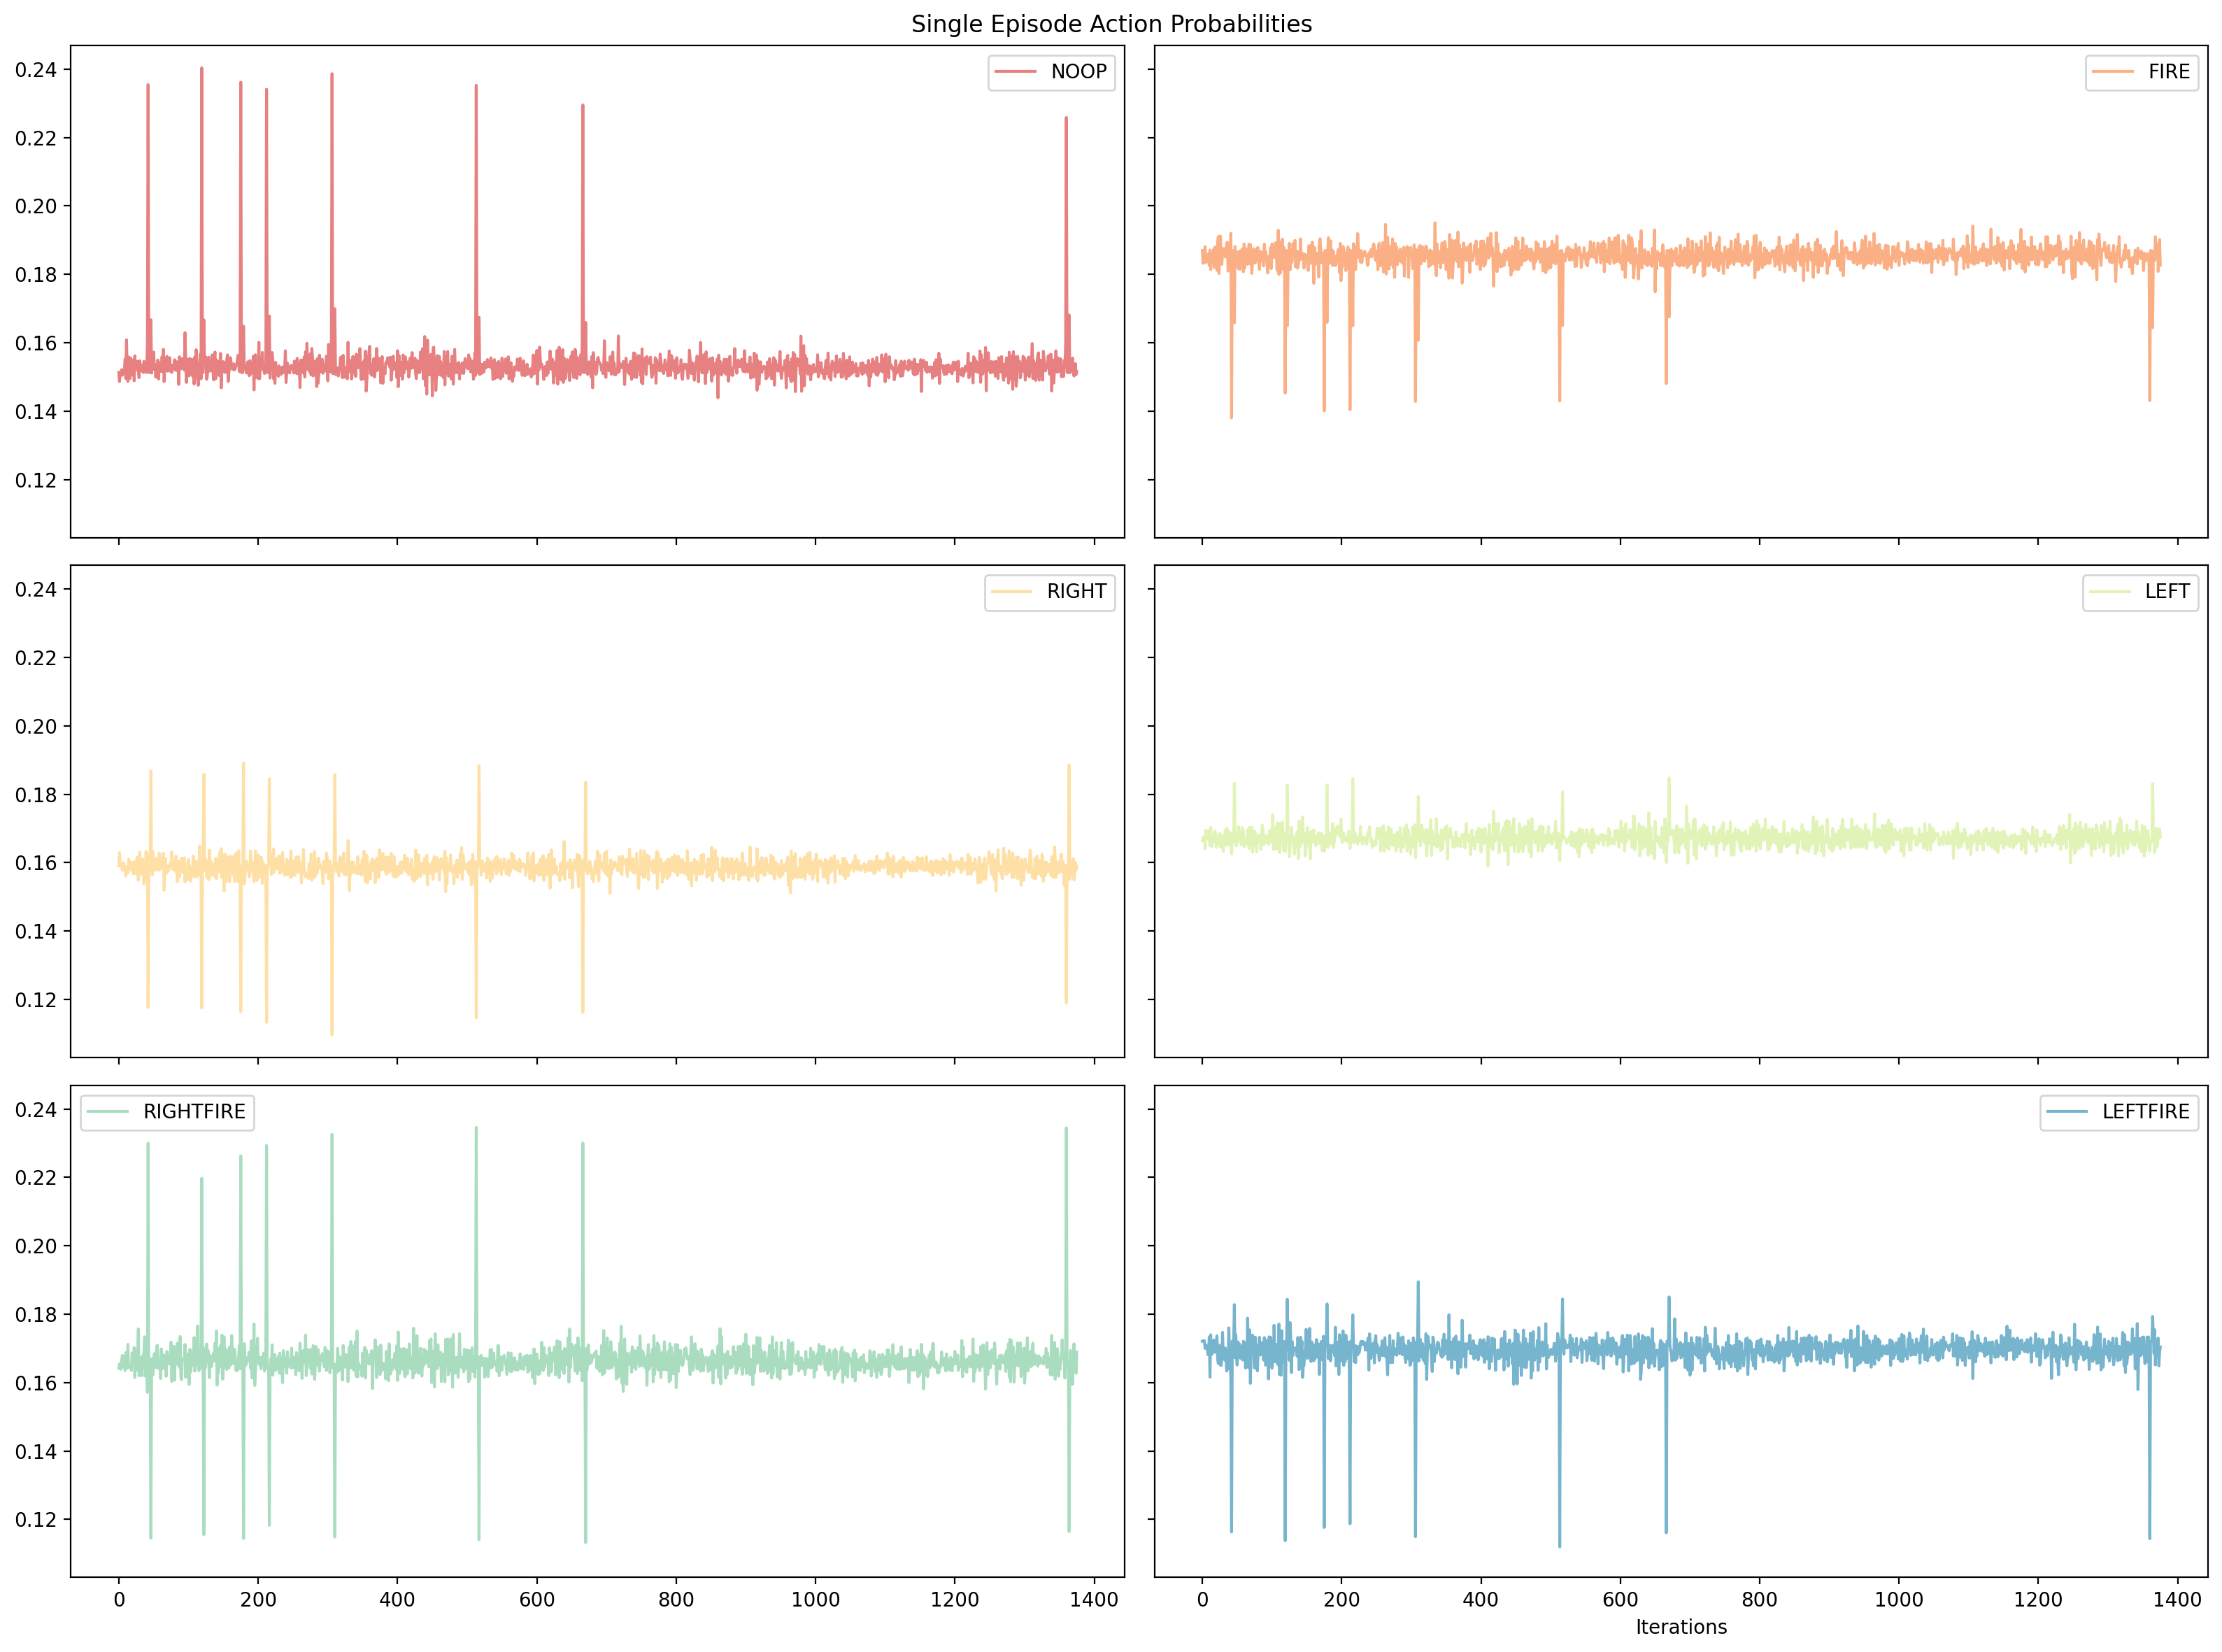

In [43]:

def plot_probs(prob_list, eps_iters_list, batch_size=64, step=1):
    probs_arr = torch.vstack(prob_list).detach().numpy()
#     plt.figure(figsize=(16,5))
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,12), dpi=200, sharex=True, sharey=True)
    fig.suptitle('Single Episode Action Probabilities')
    colors = sns.color_palette('Spectral', 7)
    colors = colors[:3] + colors[4:]
    for i, (ax, color) in enumerate(zip(axs.flatten(), colors)):
        sns.lineplot(data=probs_arr[::step,i], color=color, label=action_dict[i], alpha=.7, dashes=False, ax=ax)
#     plt.xticks(np.asarray(plt.xticks(), dtype=np.int32) * step)
#     for i, eps_iters in enumerate(eps_iters_list):
#         plt.axvline(eps_iters, 0, 1, color='red' if not i % batch_size else 'pink')
    plt.xlabel('Iterations')
    plt.ylabel('Probability')
    plt.tight_layout()
    plt.show()
    return

if record_probs:
    plot_probs(prob_list, eps_iters_list)

[40.0, 205.0]


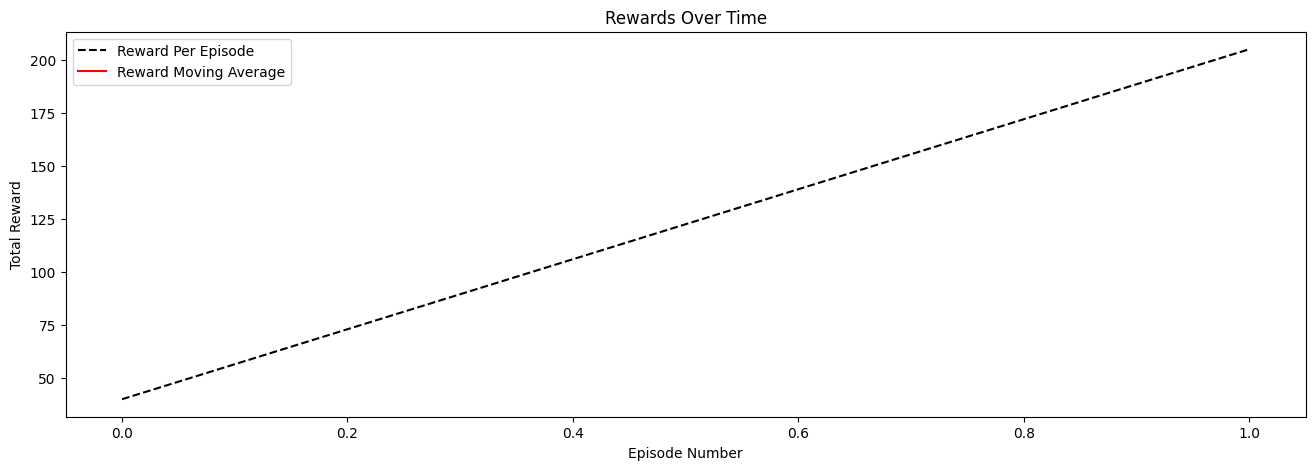

In [44]:
def moving_average(a, window_size) :
    ret = np.cumsum(a, dtype=float)
    ret[window_size:] = ret[window_size:] - ret[:-window_size]
    return ret[window_size - 1:] / window_size

def plot_rewards(reward_list, window_size=10):
    plt.figure(figsize=(16,5))
    plt.title('Rewards Over Time')
    plt.ylabel('Total Reward')
    plt.xlabel('Episode Number')
    x = np.arange(0, len(reward_list), 1)
    assert len(x) == len(reward_list)
    plt.plot(x, reward_list, color='black', linestyle='dashed', label='Reward Per Episode')
    plt.plot(x[window_size-1:], moving_average(reward_list, window_size), color='red', label='Reward Moving Average')
    plt.legend()
    plt.show()
    return

print(reward_list)
if record_rewards:
    plot_rewards(reward_list, window_size=200)